In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib,coral_pytorch

torch            : 1.10.1
pytorch_lightning: 1.6.0.dev0
torchmetrics     : 0.6.2
matplotlib       : 3.3.4
coral_pytorch    : 1.2.0



In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293,E703

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Squared-error reformulation for ordinal regression and deep learning -- cement strength dataset

Implementation of a method for ordinal regression by Beckham and Pal 2016.

**Paper reference:**

- Beckham, Christopher, and Christopher Pal. "[A simple squared-error reformulation for ordinal classification](https://arxiv.org/abs/1612.00775)." arXiv preprint arXiv:1612.00775 (2016).

**Note:**
    
To keep the notation lean and minimal, this notebook only contains "Squared-error reformulation"-specific comments. For more comments on the PyTorch Lightning use, please see the cross-entropy baseline notebook [baseline-light_cement.ipynb](./baseline-light_cement.ipynb).

## General settings and hyperparameters

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
LEARNING_RATE = 0.005
NUM_WORKERS = 0

DATA_BASEPATH = "."

## Converting a regular classifier into a *Reformulated Squared Error* ordinal regression model

Changing a classifier to a Reformulated Squared Error model for ordinal regression is actually really simple and only requires a few changes:

**1)**

We add an additional parameter layer `a`:

```python
self.a = torch.nn.Parameter(torch.zeros(
    num_classes).float().normal_(0.0, 0.1).view(-1, 1))
```


**2)**

We convert the logits (unnormalized outputs of the neural network) to "predictions" using the following function:


```python
def beckham_logits_to_predictions(logits, model, num_classes):
    probas = torch.softmax(logits, dim=1)
    predictions = ((num_classes-1)
                   * torch.sigmoid(probas.mm(model.a).view(-1)))
    return predictions
```

**3)** 

We swap the cross entropy loss from PyTorch,

```python
torch.nn.functional.cross_entropy(logits, true_labels)
```

with the squared error loss):

```python
def squared_error(targets, predictions):
    return torch.mean((targets.float() - predictions)**2)
```

**4)**

In a regular classifier, we usually obtain the predicted class labels as follows:

```python
predicted_labels = torch.argmax(logits, dim=1)
```

In this method, we replace this with the following code to convert the predicted probabilities into the predicted labels:

```python
def beckham_logits_to_labels(logits, model, num_classes):
    predictions = beckham_logits_to_predictions(logits, model, num_classes)
    return torch.round(predictions).float()

predicted_labels = beckham_logits_to_labels(logits, model, model.num_classes)
```

## Implementing a `MultiLayerPerceptron` using PyTorch Lightning's `LightningModule`

In [4]:
import torch


class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_units, num_classes):
        super().__init__()

        self.num_classes = num_classes
        
        all_layers = []
        for hidden_unit in hidden_units:
            layer = torch.nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(torch.nn.ReLU())
            input_size = hidden_unit

        output_layer = torch.nn.Linear(hidden_units[-1], num_classes)
        
        all_layers.append(output_layer)
        self.model = torch.nn.Sequential(*all_layers)
        
        # -----------------------------------------------------
        # Beckham 2016-specific parameter layer
        self.a = torch.nn.Parameter(torch.zeros(
            num_classes).float().normal_(0.0, 0.1).view(-1, 1))
        # -----------------------------------------------------        
        
    def forward(self, x):
        x = self.model(x)
        return x

Now, let's define the following Squared Error Reformulation-specific functions:

In [5]:
def squared_error(targets, predictions):
    return torch.mean((targets.float() - predictions)**2)


def beckham_logits_to_predictions(logits, model, num_classes):
    probas = torch.softmax(logits, dim=1)
    predictions = ((num_classes-1)
                   * torch.sigmoid(probas.mm(model.a).view(-1)))
    return predictions


def beckham_logits_to_labels(logits, model, num_classes):
    predictions = beckham_logits_to_predictions(logits, model, num_classes)
    return torch.round(predictions).float()

And then, we will use them below in the `LightningModule`. They are only used in the `_shared_step` method as indicated:

In [6]:
from coral_pytorch.losses import corn_loss
from coral_pytorch.dataset import corn_label_from_logits

import pytorch_lightning as pl
import torchmetrics


class LightningMLP(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=['model'])

        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.valid_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()
        
    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        # Beckham 2016-specific functions-------------------------------### 
        predictions = beckham_logits_to_predictions(
            logits, self.model, self.model.num_classes)
        
        loss = squared_error(predictions, true_labels)
        
        predicted_labels = beckham_logits_to_labels(
            logits, self.model, self.model.num_classes)
        # ---------------------------------------------------------------###   
        
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        self.train_mae(predicted_labels, true_labels)
        self.log("train_mae", self.train_mae, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_mae(predicted_labels, true_labels)
        self.log("valid_mae", self.valid_mae,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_mae(predicted_labels, true_labels)
        self.log("test_mae", self.test_mae, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

---

# Note: There Are No Changes Compared To The Baseline Below

---

## Setting up the dataset

### Inspecting the dataset

In [7]:
import pandas as pd
import numpy as np


data_df = pd.read_csv("https://raw.githubusercontent.com/gagolews/"
                      "ordinal_regression_data/master/cement_strength.csv")
data_df["response"] = data_df["response"]-1

data_labels = data_df["response"]
data_features = data_df.loc[:, [
    "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8"]]

data_df.head()

,response,V1,V2,V3,V4,V5,V6,V7,V8
0,4,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,4,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,2,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [8]:
print('Number of features:', data_features.shape[1])
print('Number of examples:', data_features.shape[0])
print('Labels:', np.unique(data_labels.values))
print('Label distribution:', np.bincount(data_labels))

Number of features: 8
Number of examples: 998
Labels: [0 1 2 3 4]
Label distribution: [196 310 244 152  96]


### Performance baseline

In [9]:
avg_prediction = np.median(data_labels.values)  # median minimizes MAE
baseline_mae = np.mean(np.abs(data_labels.values - avg_prediction))
print(f'Baseline MAE: {baseline_mae:.2f}')

Baseline MAE: 1.03


### Creating a `Dataset` class

In [10]:
from torch.utils.data import Dataset


class MyDataset(Dataset):

    def __init__(self, feature_array, label_array, dtype=np.float32):
        self.features = feature_array.astype(dtype)
        self.labels = label_array

    def __getitem__(self, index):
        inputs = self.features[index]
        label = self.labels[index]
        return inputs, label

    def __len__(self):
        return self.features.shape[0]

### Setting up a `DataModule`

In [11]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        data_df = pd.read_csv(
            'https://raw.githubusercontent.com/gagolews/'
            'ordinal_regression_data/master/cement_strength.csv')
        data_df.to_csv(
            os.path.join(self.data_path, 'cement_strength.csv'), index=None)
        return

    def setup(self, stage=None):
        data_df = pd.read_csv(
            os.path.join(self.data_path, 'cement_strength.csv'))
        data_df["response"] = data_df["response"]-1  # labels should start at 0
        self.data_labels = data_df["response"]
        self.data_features = data_df.loc[:, [
            "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8"]]
        
        # Split into
        # 70% train, 10% validation, 20% testing
        
        X_temp, X_test, y_temp, y_test = train_test_split(
            self.data_features.values,
            self.data_labels.values,
            test_size=0.2,
            random_state=1,
            stratify=self.data_labels.values)

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_temp,
            y_temp,
            test_size=0.1,
            random_state=1,
            stratify=y_temp)
        
        # Standardize features
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_valid_std = sc.transform(X_valid)
        X_test_std = sc.transform(X_test)

        self.train = MyDataset(X_train_std, y_train)
        self.valid = MyDataset(X_valid_std, y_valid)
        self.test = MyDataset(X_test_std, y_test)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.valid, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

In [12]:
torch.manual_seed(1) 
data_module = DataModule(data_path=DATA_BASEPATH)

## Training the model using the PyTorch Lightning Trainer class

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = MultiLayerPerceptron(
    input_size=data_features.shape[1],
    hidden_units=(40, 20),
    num_classes=np.bincount(data_labels).shape[0])

lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=LEARNING_RATE)


callbacks = [ModelCheckpoint(
    save_top_k=1, mode="min", monitor="valid_mae")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="mlp-beckham-cement")

In [14]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=True,
    log_every_n_steps=10)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | MultiLayerPerceptron | 1.3 K 
1 | train_mae | MeanAbsoluteError    | 0     
2 | valid_mae | MeanAbsoluteError    | 0     
3 | test_mae  | MeanAbsoluteError    | 0     
---------------------------------------------------
1.3 K     Trainable param

Validation sanity check: 0it [00:00, ?it/s]

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:258: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:258: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1850: PossibleUserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 0.30 min in total.


## Evaluating the model

<AxesSubplot:xlabel='Epoch', ylabel='MAE'>

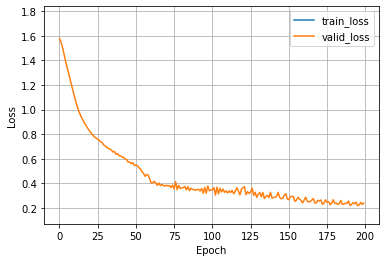

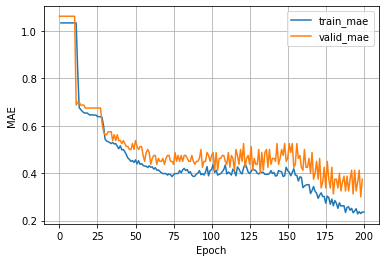

In [15]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_mae", "valid_mae"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='MAE')

In [16]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/mlp-beckham-cement/version_2/checkpoints/epoch=198-step=994.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/mlp-beckham-cement/version_2/checkpoints/epoch=198-step=994.ckpt
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:258: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mae          │    0.3400000035762787     │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 0.3400000035762787}]